### Imports

In [1]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.visualization.scatter import Scatter

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import Hypervolume

### Definición del problema

In [2]:
class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [3]:
problem = TSPProblem(100)
print(np.shape(problem.distances))
print(np.shape(problem.times))

(100, 100)
(100, 100)


### Funciones auxiliares y cálculo de métricas

#### Punto de referencia calculado: [ 5359.05729263 14825.72799702]

In [4]:
# import numpy as np
# from pymoo.optimize import minimize
# from pymoo.visualization.scatter import Scatter
# from pymoo.indicators.hv import Hypervolume
# from pymoo.termination import get_termination
# from pymoo.algorithms.moo.nsga2 import NSGA2

# def calculate_reference_point(problem, n_gens=1000, num_experiments=10):
#     """
#     Calcula el punto de referencia basado en el peor valor de 10 ejecuciones de NSGA2.

#     @param problem: Problema multiobjetivo.
#     @param n_gens: Número de generaciones por ejecución.
#     @param num_experiments: Número de ejecuciones para calcular el peor valor.

#     @return: Punto de referencia calculado.
#     """
#     worst_values = []

#     # Crear instancia del algoritmo NSGA-II
#     algorithm = NSGA2(pop_size=100)

#     for i in range(num_experiments):
#         # Ejecutar minimización
#         res = minimize(problem, algorithm, ('n_gen', n_gens), verbose=False)
#         front = res.F  # Frente de Pareto
#         # Agregar el peor punto del frente de Pareto actual
#         worst_point = np.max(front, axis=0)
#         worst_values.append(worst_point)

#     # Calcular el peor punto global
#     reference_point = np.max(worst_values, axis=0) * 1.3  # Margen de seguridad
#     print(f"Punto de referencia calculado: {reference_point}")
#     return reference_point

# ref_point = calculate_reference_point(problem, n_gens=1000, num_experiments=10)

#### Métricas utilizadas: Hipervolumen (HV), Dispersión (SPR) y Espaciado (SPA)

In [5]:
def calculate_metrics(front):
    """ Calcula las métricas: hipervolumen, dispersión (SPR) y espaciado (SPA). 
        Se utiliza un punto de referencia fijo para calcular el hipervolumen.
    """
    # Punto de referencia fijo basado en el análisis previo
    ref_point = np.array([5359.05729263, 14825.72799702])

    # Calcular el hipervolumen con respecto al punto de referencia
    metricHV = Hypervolume(ref_point)
    hv = metricHV.do(front)

    # Dispersión: Diagonal de la hipercaja que contiene el frente
    min_values = np.min(front, axis=0)  # Valor mínimo en cada objetivo
    max_values = np.max(front, axis=0)  # Valor máximo en cada objetivo
    spr = np.linalg.norm(max_values - min_values)  # Norma euclidiana de la diferencia entre máximos y mínimos

    # Espaciado: Distancia promedio entre puntos del frente
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)  # Matriz de distancias entre puntos
    spa = np.mean(np.min(d + np.diag(np.inf * np.ones(len(d))), axis=1))  # Promedio de distancias mínimas

    return hv, spr, spa

### NSGA-II

In [6]:
algorithm_nsga2 = NSGA2(pop_size=100)
# Listas para guardar métricas
metrics_summary = []
best_hypervolume = -float('inf')
best_front = None

for i in range(10):
    print(f"\nEjecución {i+1}/{10}:")

    # Ejecutar minimización
    res = minimize(problem, algorithm_nsga2, ('n_gen', 1000), verbose=False)
    front = res.F  # Frente de Pareto (valores de los objetivos)

    # Calcular métricas
    hv, spr, spa = calculate_metrics(front)
    metrics_summary.append((hv, spr, spa))
    print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

    # Guardar el mejor frente según el hipervolumen
    if hv > best_hypervolume:
        best_hypervolume = hv
        best_front = front

# Calcular promedios y desviaciones estándar de las métricas
metrics_summary = np.array(metrics_summary)
mean_metrics = np.mean(metrics_summary, axis=0)
std_metrics = np.std(metrics_summary, axis=0)

print("\n--- Resumen de Métricas ---")
print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")


Ejecución 1/10:
Hipervolumen: 24401107.4444, Dispersión (SPR): 6566.3503, Espaciado (SPA): 16.5874

Ejecución 2/10:
Hipervolumen: 26303092.1062, Dispersión (SPR): 5382.7865, Espaciado (SPA): 14.7870

Ejecución 3/10:
Hipervolumen: 25140686.6467, Dispersión (SPR): 3690.3130, Espaciado (SPA): 11.3986

Ejecución 4/10:
Hipervolumen: 27677214.8644, Dispersión (SPR): 4832.6101, Espaciado (SPA): 13.2641

Ejecución 5/10:
Hipervolumen: 27859617.5849, Dispersión (SPR): 4369.4872, Espaciado (SPA): 20.3770

Ejecución 6/10:
Hipervolumen: 26718292.7492, Dispersión (SPR): 5880.5189, Espaciado (SPA): 31.0176

Ejecución 7/10:
Hipervolumen: 25826742.4627, Dispersión (SPR): 4020.4966, Espaciado (SPA): 11.0848

Ejecución 8/10:
Hipervolumen: 27669370.3449, Dispersión (SPR): 4600.9807, Espaciado (SPA): 16.7853

Ejecución 9/10:
Hipervolumen: 26424489.6059, Dispersión (SPR): 4195.5867, Espaciado (SPA): 11.3331

Ejecución 10/10:
Hipervolumen: 27720001.3247, Dispersión (SPR): 6269.5532, Espaciado (SPA): 30.7822

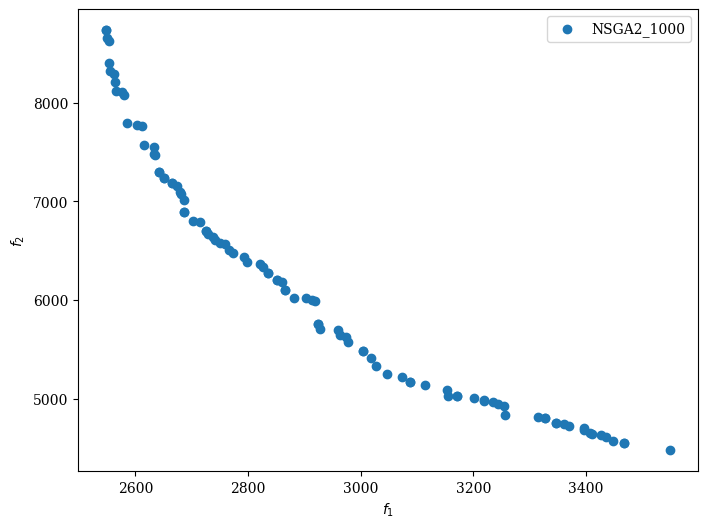

In [7]:
scatter = Scatter()
scatter.add(best_front, label="NSGA2_1000")
scatter.legend=True
scatter.show()

In [8]:
def inicializar_poblacion(n_cities, n_individuals):
    """
    Inicializa la población con permutaciones de rutas.
    
    Parameters:
    - n_cities: Número de ciudades (tamaño del cromosoma).
    - n_individuals: Número de individuos en la población.
    
    Returns:
    - Una lista de individuos (rutas).
    """
    poblacion = []
    for _ in range(n_individuals):
        individuo = np.random.permutation(n_cities).tolist()
        poblacion.append(individuo)
    return poblacion

In [9]:
def evaluar_poblacion(problem, poblacion):
    """
    Evalúa una población en términos de los objetivos multiobjetivo definidos en TSPProblem.
    
    Parameters:
    - problem: Instancia del problema TSPProblem (definido con Pymoo).
    - poblacion: Lista de individuos (rutas) a evaluar.
    
    Returns:
    - valores_objetivo: Una lista de tuplas donde cada tupla representa (distancia, tiempo) para un individuo.
    """
    # Convertimos la población en un arreglo numpy para usarlo con Pymoo
    x = np.array(poblacion)

    # Diccionario para almacenar los resultados de evaluación
    resultados = {}
    problem._evaluate(x, resultados)

    # Extraemos los valores de los objetivos (distancia y tiempo)
    valores_objetivo = resultados["F"]

    return valores_objetivo

In [10]:
def calcular_crowding_distance(valores_objetivo):
    """
    Calcula la distancia de hacinamiento (crowding distance) para un conjunto de objetivos.
    
    Parameters:
    - valores_objetivo: Matriz de objetivos (N x M).
    
    Returns:
    - crowding: Array con la distancia de hacinamiento para cada solución.
    """
    n_ind, n_obj = valores_objetivo.shape
    crowding = np.zeros(n_ind)

    # Para cada objetivo, calcular la distancia crowding
    for m in range(n_obj):
        # Ordenar por el m-ésimo objetivo
        sorted_indices = np.argsort(valores_objetivo[:, m])
        sorted_obj = valores_objetivo[sorted_indices, m]

        # Asignar infinito a los extremos (frontera del rango)
        crowding[sorted_indices[0]] = np.inf
        crowding[sorted_indices[-1]] = np.inf

        # Calcular la distancia normalizada para los intermedios
        norm = sorted_obj[-1] - sorted_obj[0]
        if norm > 0:
            for i in range(1, n_ind - 1):
                crowding[sorted_indices[i]] += (
                    (sorted_obj[i + 1] - sorted_obj[i - 1]) / norm
                )

    return crowding

In [11]:
def seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=2):
    """
    Realiza la selección por torneo para problemas multiobjetivo utilizando Pymoo.
    
    Parameters:
    - poblacion: Lista de individuos.
    - valores_objetivo: Matriz de valores objetivo (N x M).
    - n_individuals: Número de individuos a seleccionar.
    - T: Tamaño del torneo (default: 6).
    
    Returns:
    - padres: Lista de individuos seleccionados.
    """
    padres = []

    # Realizar torneo para seleccionar cada padre
    for _ in range(n_individuals):
        # Seleccionar T competidores al azar
        indices = np.random.choice(len(poblacion), size=T, replace=False)
        competidores = [poblacion[i] for i in indices]
        objetivos_competidores = valores_objetivo[indices]

        # Identificar los no dominados usando Pymoo
        nds = NonDominatedSorting()
        frentes = nds.do(objetivos_competidores, only_non_dominated_front=True)
        no_dominados = np.atleast_1d(frentes[0])  # Convertir siempre a array de al menos 1D

        if len(no_dominados) == 1:
            # Si hay un único no dominado, seleccionarlo
            ganador = competidores[no_dominados[0]]
        else:
            # Si hay empate, calcular distancia crowding
            crowding = calcular_crowding_distance(objetivos_competidores)
            idx_mejor = no_dominados[np.argmax(crowding[no_dominados])]
            ganador = competidores[idx_mejor]

        padres.append(ganador)

    return padres


In [12]:
def pmx_crossover(parent1, parent2, pcross):
    """
    Realiza un cruce PMX (Partially Mapped Crossover) entre dos padres con probabilidad de cruce.

    Parameters:
    - parent1: Individuo padre 1 (lista de ciudades).
    - parent2: Individuo padre 2 (lista de ciudades).
    - pcross: Probabilidad de cruce.

    Returns:
    - child1: Hijo 1 generado a partir de los padres.
    - child2: Hijo 2 generado a partir de los padres.
    """
    # Verificar si se realiza el cruce con la probabilidad dada
    if np.random.rand() >= pcross:
        # No realizar cruce, devolver copias de los padres
        return parent1[:], parent2[:]

    size = len(parent1)
    start, end = sorted(np.random.choice(range(size), 2, replace=False))  # Extremos de la máscara

    child1 = [-1] * size
    child2 = [-1] * size

    # Copiar segmento de parent1 a child1 y de parent2 a child2
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]

    # Crear mapeos entre los segmentos
    mapping1 = {parent1[i]: parent2[i] for i in range(start, end)}
    mapping2 = {parent2[i]: parent1[i] for i in range(start, end)}

    def fill_child(child, parent, mapping):
        for i in range(size):
            if child[i] == -1:  # Si la posición está vacía
                gene = parent[i]
                while gene in mapping:
                    gene = mapping[gene]  # Resolver conflictos utilizando el mapeo
                child[i] = gene
        return child

    # Llenar los hijos utilizando los mapeos
    child1 = fill_child(child1, parent2, mapping1)
    child2 = fill_child(child2, parent1, mapping2)

    return child1, child2

In [13]:
def mutate_swap(ind, pmut):
    """
    Realiza una mutación por intercambio en un individuo.

    Parameters:
    - ind: Individuo a mutar (lista de ciudades).
    - pmut: Probabilidad de mutación.

    Returns:
    - ind: Individuo mutado.
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            j = np.random.randint(0, len(ind))
            ind[i], ind[j] = ind[j], ind[i]
    return ind


def mutate_insert(ind, pmut):
    """
    Realiza una mutación por inserción en un individuo.

    Parameters:
    - ind: Individuo a mutar (lista de ciudades).
    - pmut: Probabilidad de mutación.

    Returns:
    - ind: Individuo mutado.
    """
    for i in range(len(ind)):
        if np.random.rand() < pmut:
            gene = ind.pop(i)
            j = np.random.randint(0, len(ind))
            ind.insert(j, gene)
    return ind


def mutate_reverse(ind, pmut):
    """
    Realiza una mutación por inversión en un individuo.

    Parameters:
    - ind: Individuo a mutar (lista de ciudades).
    - pmut: Probabilidad de mutación.

    Returns:
    - ind: Individuo mutado.
    """
    if np.random.rand() < pmut:
        i, j = sorted(np.random.choice(range(len(ind)), 2, replace=False))
        ind[i:j] = reversed(ind[i:j])
    return ind


mutations = [mutate_swap, mutate_insert, mutate_reverse]

def mutate(ind, pmut):
    """
    Aplica un operador de mutación seleccionado aleatoriamente a un individuo.

    Parameters:
    - ind: Individuo a mutar.
    - pmut: Probabilidad de mutación.

    Returns:
    - Individuo mutado.
    """
    mutation_operator = np.random.choice(mutations)
    return mutation_operator(ind, pmut)

In [14]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):
    """
    Evoluciona una población usando operadores genéticos para resolver un problema multiobjetivo TSP,
    e imprime la cantidad de soluciones no dominadas cada `trace` generaciones, incluyendo la final.
    """
    # Inicializar la población
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)

    # Evaluar la población inicial
    valores_objetivo = evaluar_poblacion(problem, poblacion)

    # Preparar el NonDominatedSorting de pymoo
    nd_sort = NonDominatedSorting()

    # Recorremos de 1 a n_generations
    for gen in range(1, n_generations + 1):
        # Selección de padres usando torneo con tamaño T
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)

        # Crear una nueva población
        nueva_poblacion = []

        # Reproducción (cruce y mutación)
        while len(nueva_poblacion) < n_individuals:
            # Seleccionar dos padres al azar
            padre1, padre2 = random.sample(padres, 2)

            # Cruce PMX con probabilidad pcross
            hijo1, hijo2 = pmx_crossover(padre1, padre2, pcross)

            # Mutación de los hijos
            hijo1 = mutate(hijo1, pmut)
            hijo2 = mutate(hijo2, pmut)

            # Agregar hijos a la nueva población
            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        # Actualizar la población
        poblacion = nueva_poblacion

        # Evaluar la nueva población
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Cada `trace` generaciones y en la última, imprimimos la traza
        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
            n_nd = len(nd_front)
            print(f"Generación {gen}: {n_nd} soluciones no dominadas.")

    nd_front = nd_sort.do(valores_objetivo, only_non_dominated_front=True)

    return poblacion, valores_objetivo

#### Función para ejecutar algoritmo 10 veces y guardar resultados y métricas

In [15]:
def multiple_experiments_with_metrics(problem, n_generations, n_individuals, pcross, pmut, trace=250, T=6, num_experiments=10):
    """
    Ejecuta el método `evolve` múltiples veces y recoge las métricas de cada ejecución.

    @param problem: Problema multiobjetivo.
    @param n_generations: Número de generaciones.
    @param n_individuals: Tamaño de la población.
    @param pcross: Probabilidad de cruce.
    @param pmut: Probabilidad de mutación.
    @param trace: Intervalo de impresión de progreso.
    @param T: Tamaño del torneo de selección.
    @param num_experiments: Número de experimentos a realizar.

    @return: Resumen de métricas y el mejor frente de Pareto encontrado.
    """
    metrics_summary = []
    best_hypervolume = -float('inf')
    best_front = None

    for i in range(num_experiments):
        print(f"\nEjecución {i+1}/{num_experiments}:")

        # Ejecutar `evolve`
        _, valores_objetivo = evolve(
            problem=problem,
            n_generations=n_generations,
            n_individuals=n_individuals,
            pcross=pcross,
            pmut=pmut,
            trace=trace,
            T=T
        )

        # Obtener el frente no dominado
        nd_sort = NonDominatedSorting()
        nd_front_indices = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front = valores_objetivo[nd_front_indices]

        # Calcular métricas
        hv, spr, spa = calculate_metrics(front)
        metrics_summary.append((hv, spr, spa))

        print(f"Hipervolumen: {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")

        # Guardar el mejor frente según el hipervolumen
        if hv > best_hypervolume:
            best_hypervolume = hv
            best_front = front

    # Calcular promedios y desviaciones estándar
    metrics_summary = np.array(metrics_summary)
    mean_metrics = np.mean(metrics_summary, axis=0)
    std_metrics = np.std(metrics_summary, axis=0)

    print("\n--- Resumen de Métricas ---")
    print(f"Promedio de Hipervolumen: {mean_metrics[0]:.4f} ± {std_metrics[0]:.4f}")
    print(f"Promedio de Dispersión (SPR): {mean_metrics[1]:.4f} ± {std_metrics[1]:.4f}")
    print(f"Promedio de Espaciado (SPA): {mean_metrics[2]:.4f} ± {std_metrics[2]:.4f}")

    return best_front, metrics_summary

In [16]:
best_individual_evolve, metrics_summary_evolve = multiple_experiments_with_metrics(problem, n_generations=1000, n_individuals=100, pcross=0.7, pmut=0.01, trace=100, T=6, num_experiments=10)


Ejecución 1/10:
Generación 1: 12 soluciones no dominadas.
Generación 100: 27 soluciones no dominadas.
Generación 200: 52 soluciones no dominadas.
Generación 300: 54 soluciones no dominadas.
Generación 400: 48 soluciones no dominadas.
Generación 500: 39 soluciones no dominadas.
Generación 600: 64 soluciones no dominadas.
Generación 700: 43 soluciones no dominadas.
Generación 800: 48 soluciones no dominadas.
Generación 900: 54 soluciones no dominadas.
Generación 1000: 65 soluciones no dominadas.
Final - 65 soluciones no dominadas
Final population size: 100
Shape valores_objetivo: (100, 2)
Hipervolumen: 21560654.2517, Dispersión (SPR): 845.6523, Espaciado (SPA): 1.7995

Ejecución 2/10:
Generación 1: 4 soluciones no dominadas.
Generación 100: 40 soluciones no dominadas.
Generación 200: 56 soluciones no dominadas.
Generación 300: 7 soluciones no dominadas.
Generación 400: 49 soluciones no dominadas.
Generación 500: 56 soluciones no dominadas.
Generación 600: 52 soluciones no dominadas.
Gen

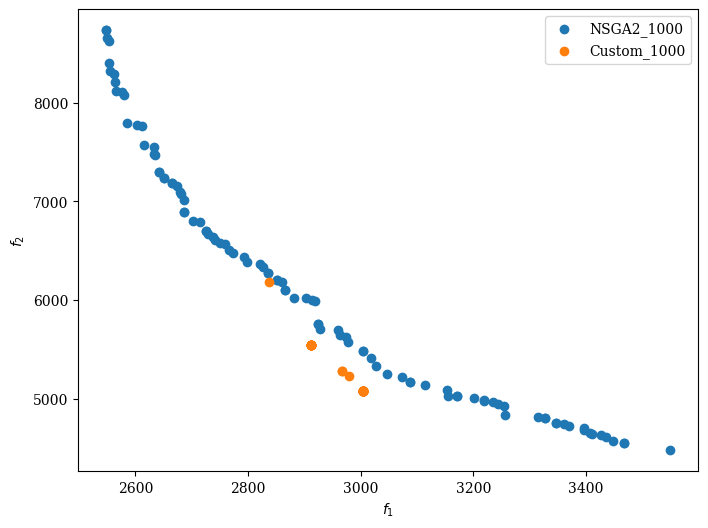

In [17]:
scatter = Scatter()
scatter.add(best_front, label="NSGA2_1000")
scatter.add(best_individual_evolve, label="Custom_1000")
scatter.legend=True
scatter.show()

In [18]:
def evolve(problem, n_generations, n_individuals, pcross, pmut, trace=10, T=2):
    """
    Evoluciona una población y registra métricas en cada generación.
    """
    poblacion = inicializar_poblacion(problem.n_var, n_individuals)
    valores_objetivo = evaluar_poblacion(problem, poblacion)
    nd_sort = NonDominatedSorting()

    # Diccionario para guardar métricas en cada generación
    metrics_by_gen = {"generation": [], "hv": [], "spr": [], "spa": []}

    for gen in range(1, n_generations + 1):
        padres = seleccionar_poblacion(poblacion, valores_objetivo, n_individuals, T=T)
        nueva_poblacion = []

        while len(nueva_poblacion) < n_individuals:
            padre1, padre2 = random.sample(padres, 2)
            hijo1, hijo2 = pmx_crossover(padre1, padre2, pcross)
            hijo1 = mutate(hijo1, pmut)
            hijo2 = mutate(hijo2, pmut)
            nueva_poblacion.append(hijo1)
            if len(nueva_poblacion) < n_individuals:
                nueva_poblacion.append(hijo2)

        poblacion = nueva_poblacion
        valores_objetivo = evaluar_poblacion(problem, poblacion)

        # Obtener el frente no dominado
        nd_front_indices = nd_sort.do(valores_objetivo, only_non_dominated_front=True)
        front = valores_objetivo[nd_front_indices]

        # Calcular métricas en la generación actual
        hv, spr, spa = calculate_metrics(front)
        metrics_by_gen["generation"].append(gen)
        metrics_by_gen["hv"].append(hv)
        metrics_by_gen["spr"].append(spr)
        metrics_by_gen["spa"].append(spa)

        if (gen == 1) or (gen % trace == 0) or (gen == n_generations):
            print(f"Generación {gen}: Hipervolumen={hv:.4f}, Dispersión={spr:.4f}, Espaciado={spa:.4f}")

    return poblacion, valores_objetivo, metrics_by_gen


Generación 1: Hipervolumen=1581053.0032, Dispersión=2983.6428, Espaciado=710.6723
Generación 100: Hipervolumen=14789027.5999, Dispersión=849.9684, Espaciado=34.6852
Generación 200: Hipervolumen=15562299.8469, Dispersión=768.4547, Espaciado=15.7326
Generación 300: Hipervolumen=16241967.3446, Dispersión=634.6197, Espaciado=10.4449
Generación 400: Hipervolumen=17846849.6293, Dispersión=338.6574, Espaciado=2.1086
Generación 500: Hipervolumen=18551406.3589, Dispersión=725.1766, Espaciado=14.4328
Generación 600: Hipervolumen=20216585.6924, Dispersión=1068.0671, Espaciado=10.2860
Generación 700: Hipervolumen=19860142.2272, Dispersión=872.8239, Espaciado=10.7170
Generación 800: Hipervolumen=20116721.1727, Dispersión=398.2876, Espaciado=0.0000
Generación 900: Hipervolumen=21573161.6833, Dispersión=594.4013, Espaciado=6.4360
Generación 1000: Hipervolumen=21701346.8087, Dispersión=774.6757, Espaciado=33.2500


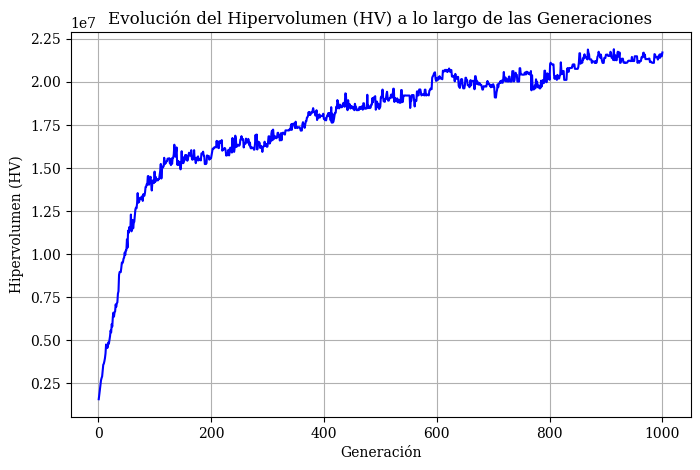

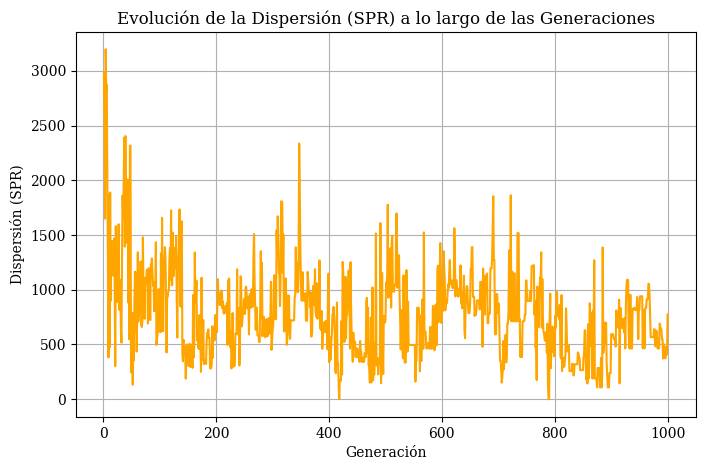

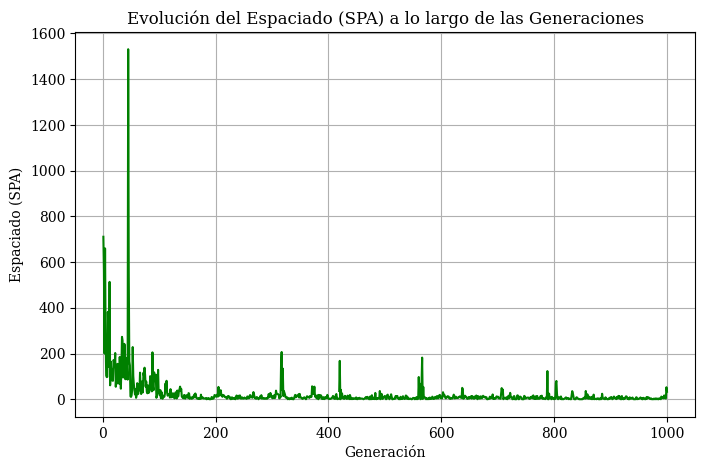

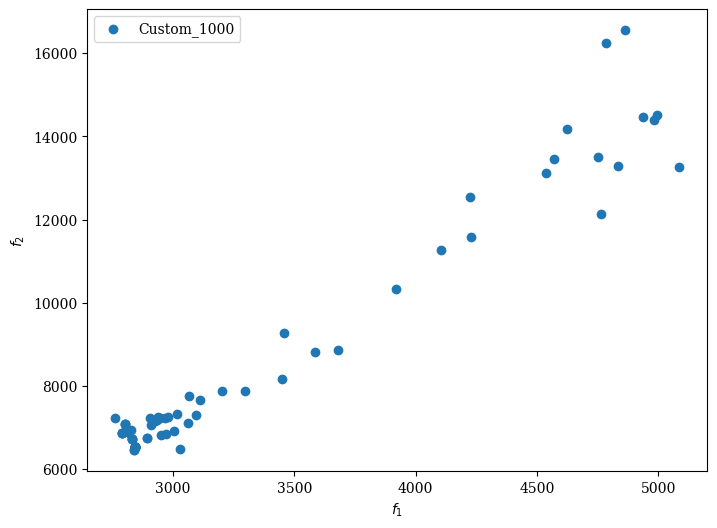

In [24]:
import matplotlib.pyplot as plt

# Ejecutar evolve y obtener las métricas por generación
_, valores_objetivo, metrics_by_gen = evolve(
    problem=problem, 
    n_generations=1000, 
    n_individuals=100, 
    pcross=0.9, 
    pmut=0.01, 
    trace=100, 
    T=6
)

import matplotlib.pyplot as plt

# Graficar el hipervolumen
plt.figure(figsize=(8, 5))
plt.plot(metrics_by_gen["generation"], metrics_by_gen["hv"], label="Hipervolumen (HV)", color='blue')
plt.xlabel("Generación")
plt.ylabel("Hipervolumen (HV)")
plt.title("Evolución del Hipervolumen (HV) a lo largo de las Generaciones")
plt.grid(True)
plt.show()

# Graficar la dispersión
plt.figure(figsize=(8, 5))
plt.plot(metrics_by_gen["generation"], metrics_by_gen["spr"], label="Dispersión (SPR)", color='orange')
plt.xlabel("Generación")
plt.ylabel("Dispersión (SPR)")
plt.title("Evolución de la Dispersión (SPR) a lo largo de las Generaciones")
plt.grid(True)
plt.show()

# Graficar el espaciado
plt.figure(figsize=(8, 5))
plt.plot(metrics_by_gen["generation"], metrics_by_gen["spa"], label="Espaciado (SPA)", color='green')
plt.xlabel("Generación")
plt.ylabel("Espaciado (SPA)")
plt.title("Evolución del Espaciado (SPA) a lo largo de las Generaciones")
plt.grid(True)
plt.show()

scatter = Scatter()
scatter.add(valores_objetivo, label="Custom_1000")
scatter.legend=True
scatter.show()

